## PUBG Modelling

플레이어들이 전장에서 벌이는 모든 행위를 분류하여 승리를 예측하기 위한 프로젝트

## Column 별 정보
- ASSISTS : 자신에 의해 사살되지는 못했지만 자신의 데미지 지분율이 가장 높은 적의 수
- BOOSTS : 도핑 아이템 사용 횟수(에너지 드링크, 진통제, 아드레날린 주사기)
- DAMAGEDEALT : 적에게 가한 전체 데미지
- DBNOS : 기절시킨 적의 수
- GROUPID : 경기 내 그룹 식별 ID
- HEADSHOTKILLS : 헤드샷으로 죽인 적의 수
- HEALS : 회복 아이템 사용 횟수(붕대, 구급상자, 의료용 키트)
- ID : 해당 데이터 ID
- KILLPLACE : 경기 내 적을 죽인 적 수의 순위
- KILLPOINTS : 유저의 ELO레이팅(죽인 적 수 기반)
- KILLS : 경기 내 적을 죽인 수
- KILLSTREAKS : 짧은 시간 내에 연속으로 적을 죽인 수
- LONGESTKILL : 사살한 적까지의 거리의 최대값
- MATCHDURATION : 경기가 진행된 시간(단위:초)
- MATCHID : 경기 식별 ID
- MATCHTYPE : 경기 모드( ex: 솔로, 듀오, 스쿼드 )
- MAXPLACE : 경기 내 총 인원 수
- NUMGROUP : 경기 내 실제 참여 인원 수
- RANKPOINTS : 유저의 ELO 레이팅
- REVIVES : 유저가 팀원을 부활시킨 횟수
- RIDEDISTANCE : 이동수단을 통해 이동한 거리(단위:m)
- ROADKILLS : 이동수단으로 살해한 적의 수
- SWIMDISTANCE : 수영으로 이동한 거리(단위:m)
- TEAMKILLS : 같은 팀원을 살해한 수
- VEHICLEDESTROYS : 파괴한 이동수단의 수
- WALKDISTANCE : 도보로 이동한 거리(단위:m)
- WEAPONSACQUIRED : 획득한 무기의 수
- WINPOINTS : 유저의 ELO 레이팅(승리 횟수 기반)
- WINPLACEPERC : 현재 경기에서의 백분위 기반 유저의 순위(종속변수)

# 라이브러리 및 데이터 불러오기

In [124]:
# 데이터 분석
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
# VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

# others 
import random
import scipy as sp
from scipy import stats
import sys
import gc
import os
print(os.listdir("./data/pubg-finish-placement-prediction/"))
import warnings                      
warnings.filterwarnings("ignore")

['test_V2.csv', 'sample_submission_V2.csv', 'train_V2.csv']


In [126]:
train = pd.read_csv("./data/pubg-finish-placement-prediction/train_V2.csv")
test = pd.read_csv("./data/pubg-finish-placement-prediction/test_V2.csv")
submission = pd.read_csv("./data/pubg-finish-placement-prediction/sample_submission_V2.csv")

In [3]:
print(train.shape, test.shape)

(4446966, 29) (1934174, 28)


In [4]:
def sorted_corr(data, column) :
    df_corr = data.corr()
    df_corr = df_corr.apply(lambda x: round(x ,2))
    df_corr = df_corr.unstack()
    df_corr = pd.DataFrame(df_corr[column][df_corr[column]<1].sort_values(ascending=False), columns=['Correlation'])
    df_corr = df_corr.style.background_gradient(cmap='coolwarm_r')
    return df_corr

In [128]:
def toVIF(features): 
    return pd.DataFrame({
        "feature": features.columns,
        "VIF": [variance_inflation_factor(features.values, idx)
                for idx in range(features.shape[1])]
    })

In [6]:
def OLS_summary(features, target):
    sm_feature = sm.add_constant(features)
    model = sm.OLS(target, sm_feature).fit()
    print(model.summary2())

## 전처리 

In [7]:
train.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00000,0,0,0,60,...,0,0.00000,0,0.00000,0,0,244.80000,1,1466,0.44440
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47000,0,0,0,57,...,0,0.00450,0,11.04000,0,0,1434.00000,5,0,0.64000
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00000,0,0,0,47,...,0,0.00000,0,0.00000,0,0,161.80000,2,0,0.77550
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90000,0,0,0,75,...,0,0.00000,0,0.00000,0,0,202.70000,3,0,0.16670
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00000,0,0,0,45,...,0,0.00000,0,0.00000,0,0,49.75000,2,0,0.18750


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Id               object 
 1   groupId          object 
 2   matchId          object 
 3   assists          int64  
 4   boosts           int64  
 5   damageDealt      float64
 6   DBNOs            int64  
 7   headshotKills    int64  
 8   heals            int64  
 9   killPlace        int64  
 10  killPoints       int64  
 11  kills            int64  
 12  killStreaks      int64  
 13  longestKill      float64
 14  matchDuration    int64  
 15  matchType        object 
 16  maxPlace         int64  
 17  numGroups        int64  
 18  rankPoints       int64  
 19  revives          int64  
 20  rideDistance     float64
 21  roadKills        int64  
 22  swimDistance     float64
 23  teamKills        int64  
 24  vehicleDestroys  int64  
 25  walkDistance     float64
 26  weaponsAcquired  int64  
 27  winPoints   

In [9]:
train.isna().sum()

Id                 0
groupId            0
matchId            0
assists            0
boosts             0
damageDealt        0
DBNOs              0
headshotKills      0
heals              0
killPlace          0
killPoints         0
kills              0
killStreaks        0
longestKill        0
matchDuration      0
matchType          0
maxPlace           0
numGroups          0
rankPoints         0
revives            0
rideDistance       0
roadKills          0
swimDistance       0
teamKills          0
vehicleDestroys    0
walkDistance       0
weaponsAcquired    0
winPoints          0
winPlacePerc       1
dtype: int64

In [10]:
train[train.winPlacePerc.isna()]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
2744604,f70c74418bb064,12dfbede33f92b,224a123c53e008,0,0,0.00000,0,0,0,1,...,0,0.00000,0,0.00000,0,0,0.00000,0,0,NaN


In [11]:
train = train.dropna(axis=0)

In [12]:
train.isna().sum()

Id                 0
groupId            0
matchId            0
assists            0
boosts             0
damageDealt        0
DBNOs              0
headshotKills      0
heals              0
killPlace          0
killPoints         0
kills              0
killStreaks        0
longestKill        0
matchDuration      0
matchType          0
maxPlace           0
numGroups          0
rankPoints         0
revives            0
rideDistance       0
roadKills          0
swimDistance       0
teamKills          0
vehicleDestroys    0
walkDistance       0
weaponsAcquired    0
winPoints          0
winPlacePerc       0
dtype: int64

In [13]:
train.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00000,0,0,0,60,...,0,0.00000,0,0.00000,0,0,244.80000,1,1466,0.44440
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47000,0,0,0,57,...,0,0.00450,0,11.04000,0,0,1434.00000,5,0,0.64000
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00000,0,0,0,47,...,0,0.00000,0,0.00000,0,0,161.80000,2,0,0.77550
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90000,0,0,0,75,...,0,0.00000,0,0.00000,0,0,202.70000,3,0,0.16670
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00000,0,0,0,45,...,0,0.00000,0,0.00000,0,0,49.75000,2,0,0.18750


In [14]:
group_lists = ["squad-fpp","squad","normal-squad-fpp","normal-squad","duo-fpp","duo","normal-duo-fpp","normal-duo"]
train_group = train.loc[train["matchType"].isin(group_lists)]
solo_lists = ["solo-fpp","solo","normal-solo-fpp","normal-solo"]
train_solo = train.loc[train["matchType"].isin(solo_lists)]

In [106]:
Dsquadfpp = train[train['matchType'] == 'squad-fpp']
Dduofpp = train[train['matchType'] == 'duo-fpp']
Dsolofpp = train[train['matchType'] == 'solo-fpp']
Dsquad = train[train['matchType'] == 'squad']
Dduo = train[train['matchType'] == 'duo']
Dsolo = train[train['matchType'] == 'solo']
Dothers = train[(train['matchType'].str.contains('normal')) | 
                   (train['matchType'].str.contains('crash')) | 
                   train['matchType'].str.contains('flare')]

## 데이터 분석

## Column별 분석

### MatchType

In [16]:
train['matchType'].value_counts()

squad-fpp           1756186
duo-fpp              996691
squad                626526
solo-fpp             536761
duo                  313591
solo                 181943
normal-squad-fpp      17174
crashfpp               6287
normal-duo-fpp         5489
flaretpp               2505
normal-solo-fpp        1682
flarefpp                718
normal-squad            516
crashtpp                371
normal-solo             326
normal-duo              199
Name: matchType, dtype: int64

In [17]:
train_mt = train.loc[:,"matchType"].value_counts().to_frame().reset_index()
train_mt.columns = ["Type","Count"]
train_mt

,Type,Count
0,squad-fpp,1756186
1,duo-fpp,996691
2,squad,626526
3,solo-fpp,536761
4,duo,313591
5,solo,181943
6,normal-squad-fpp,17174
7,crashfpp,6287
8,normal-duo-fpp,5489
9,flaretpp,2505


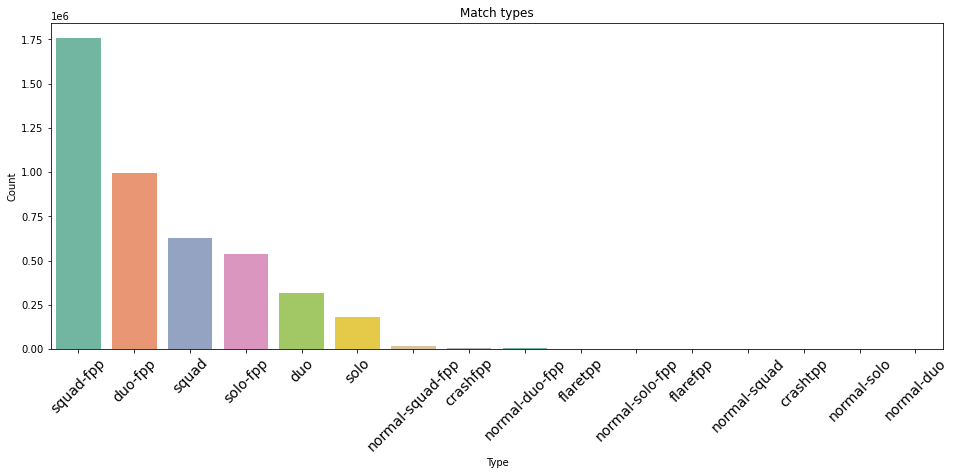

In [18]:
plt.figure(figsize=(16,6))
sns.barplot(x="Type", y="Count", data=train_mt, palette="Set2")
plt.xticks(rotation=45, fontsize=14)
plt.title("Match types")
plt.show()

- Squad-fpp 모드와 duo-fpp 모드가 제일 많은것으로 보인다

In [19]:
temp = train.loc[:,"matchType"].value_counts().to_frame()
squad = temp.loc[["squad-fpp","squad","normal-squad-fpp","normal-squad"],"matchType"].sum()
duo = temp.loc[["duo-fpp","duo","normal-duo-fpp","normal-duo"],"matchType"].sum()
solo = temp.loc[["solo-fpp","solo","normal-solo-fpp","normal-solo"],"matchType"].sum()
match_type = pd.DataFrame([squad,duo,solo], index=["squad","duo","solo"], columns =["count"])
match_type

,count
squad,2400402
duo,1315970
solo,720712


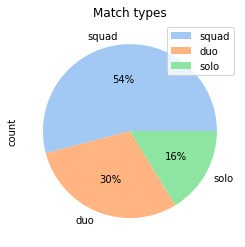

In [20]:
palette = sns.color_palette('pastel')
match_type.plot.pie(y="count", colors=palette, autopct='%.0f%%');
plt.title("Match types")
plt.show()

- Squad 경기수가 제일 많고 그다음으로 duo, solo로 많다.

### Kills 

In [21]:
train['kills'].quantile(0.999)

12.0

In [22]:
train['kills'].value_counts()

0     2529721
1      928079
2      472466
3      232441
4      124543
5       66577
6       37960
7       21816
8       12779
9        7644
10       4599
11       2799
12       1755
13       1137
14        757
15        484
16        325
17        234
18        165
19        112
20        109
22         77
21         70
23         47
24         44
25         27
26         27
28         22
27         21
30         13
29         13
31         13
33         12
36          8
38          7
35          7
34          5
41          5
37          5
32          4
53          4
40          4
39          4
43          3
42          3
56          2
55          2
44          2
46          2
57          2
49          1
45          1
47          1
48          1
50          1
66          1
65          1
72          1
Name: kills, dtype: int64

In [23]:
kills= train.copy()
kills.loc[kills['kills'] >= 13] = '13+'
train_ks = kills.loc[:,"kills"].value_counts().to_frame().reset_index()
train_ks.columns = ["Type","Count"]
train_ks

,Type,Count
0,0,2529721
1,1,928079
2,2,472466
3,3,232441
4,4,124543
5,5,66577
6,6,37960
7,7,21816
8,8,12779
9,9,7644


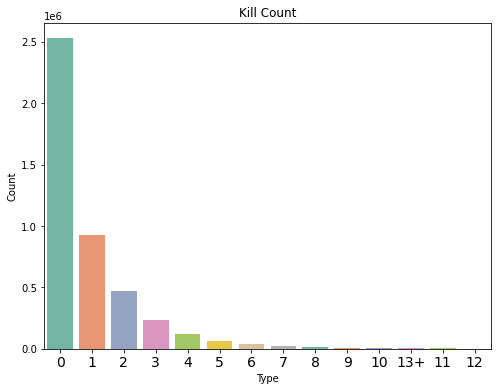

In [24]:
plt.figure(figsize=(8,6))
sns.barplot(x="Type", y="Count", data=train_ks, palette="Set2")
plt.xticks(fontsize=14)
plt.title("Kill Count")
plt.show()

- 대다수의 사람들이 0킬이나 1킬을 한것으로 보여진다

#### 킬수와 승리와의 상관관계

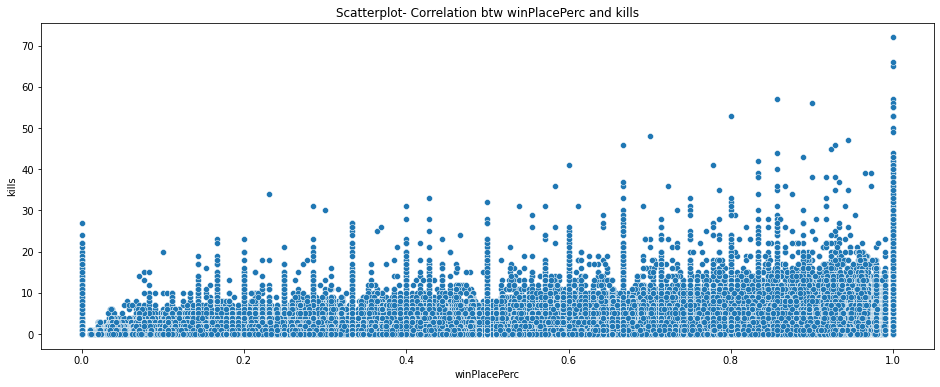

In [25]:
plt.figure(figsize=(16,6))
sns.scatterplot(data=train, x='winPlacePerc', y='kills')
plt.title("Scatterplot- Correlation btw winPlacePerc and kills")
plt.show()

- 킬수와 승리와의 상관관계는 존재한다
- 킬수가 높을수록 승리할 확률이 높다

### damageDealt 

#### 킬수와 데미지간의 상관관계

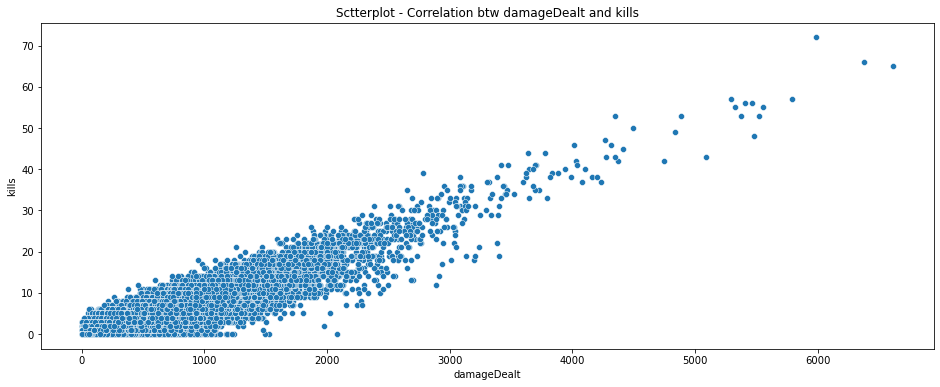

In [26]:
plt.figure(figsize=(16,6))
sns.scatterplot(data=train, x="damageDealt", y="kills")
plt.title("Sctterplot - Correlation btw damageDealt and kills")
plt.show()

- 킬수와 데미지는 양의 상관관계를 가진다 
- 킬수가 높을수록 데미지가 높다

In [27]:
train[train.kills>60]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
334400,810f2379261545,7f3e493ee71534,f900de1ec39fa5,20,0,6616.00000,0,13,5,1,...,0,0.00000,0,0.00000,0,0,1036.00000,60,0,1.00000
1248348,80ac0bbf58bfaf,1e54ab4540a337,08e4c9e6c033e2,5,0,6375.00000,0,21,4,1,...,0,0.00000,0,0.00000,0,0,1740.00000,23,0,1.00000
3431247,06308c988bf0c2,4c4ee1e9eb8b5e,6680c7c3d17d48,7,4,5990.00000,0,64,10,1,...,0,0.00000,0,0.00000,0,0,728.10000,35,0,1.00000


- 60킬 이상 한사람들의 데이터를 보면 걸은 거리가 그렇게 많지는 않은데 
- 한곳에 여러명이 떨어져서 그 지역에서 킬을 몰아서 먹은것으로 예상된다
- 아니면 불법 프로그램을 사용했을까?

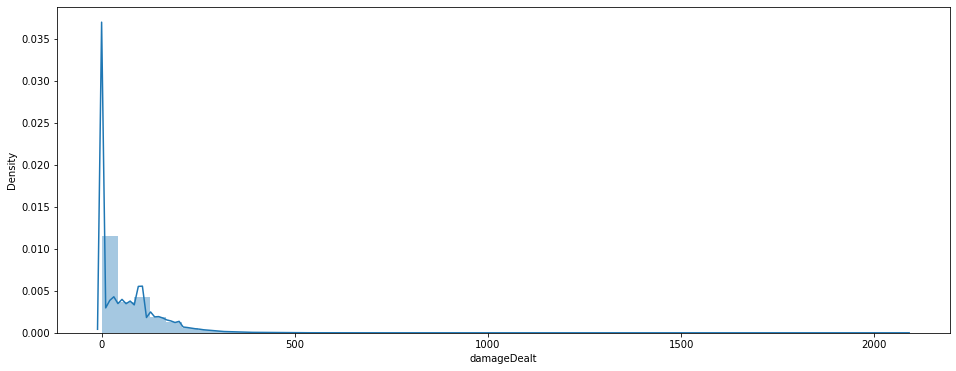

In [28]:
df = train.copy()
df = df[df['kills']<=1]

plt.figure(figsize=(16,6))
sns.distplot(df['damageDealt'])
plt.show()

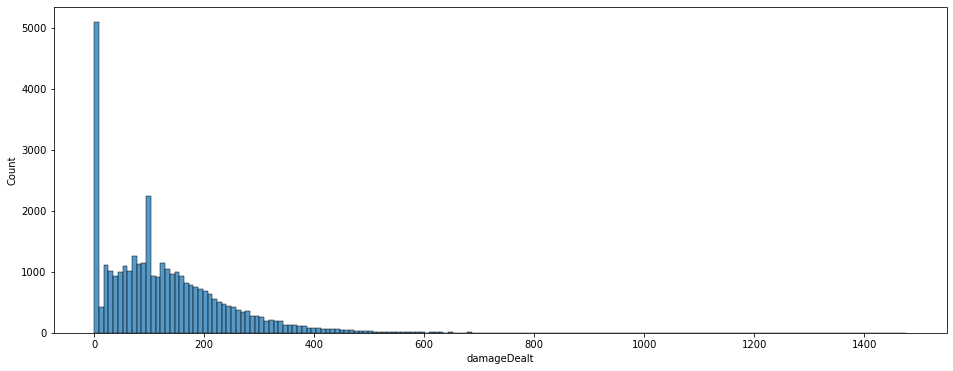

In [29]:
df = df[df['winPlacePerc'] == 1.0]
plt.figure(figsize=(16,6))
sns.histplot(data=df, x='damageDealt')
plt.show()

#### 데미지가 0인 사람들의 matchType

In [30]:
df1 = df[df['damageDealt']==0]
print(len(df), len(df1))

35349 4765


In [31]:
df1['matchType'].value_counts()

squad-fpp           2705
squad               1229
solo                 313
duo-fpp              297
duo                  125
normal-squad-fpp      70
crashfpp               9
normal-duo-fpp         6
normal-squad           3
crashtpp               3
solo-fpp               1
flaretpp               1
normal-duo             1
normal-solo            1
normal-solo-fpp        1
Name: matchType, dtype: int64

In [32]:
df1['matchType'].str.contains('squad').sum()

4007

In [33]:
df1_squad = df1['matchType'].str.contains('squad').sum()
df1_duo = df1['matchType'].str.contains('duo').sum()
df1_solo = df1['matchType'].str.contains('solo').sum()
df1_mt = pd.DataFrame([df1_squad,df1_duo,df1_solo], index=["squad","duo","solo"], columns =["count"])
df1_mt

,count
squad,4007
duo,429
solo,316


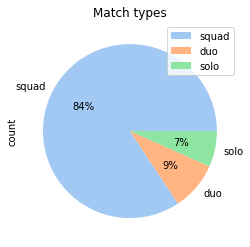

In [34]:
palette = sns.color_palette('pastel')
df1_mt.plot.pie(y="count", colors=palette, autopct='%.0f%%');
plt.title("Match types")
plt.show()

- 데미지가 0으로 우승한 사람들은 squad가 대부분이다
- 솔로에서 데미지가 0으로 우승한 사람들 316명은 핵으로 취급하거나
- 운이 좋아서 아무것도 안하고 이겼다고 볼수있을거 같다 (e.g. 마지막 한명이 자기장밖에서 죽거나, 마지막 두명이 서로 싸우다 자멸하거나)

- 킬수와 승리의 상관관계는 존재한다
- 킬수가 높을수록 승리를 할 확률이 높다
- 킬수와 데미지의 상관관계는 존재한다
- 킬수가 높을수록 데미지가 높다
- 킬수가 낮거나 없는 사람들중에 승리한 사람들은 좋은 팀을 만나 승리한것으로 보여진다
- 킬수가 낮거나 없는 사람들중에 승리한 사람들은 데미지를 제대로 주지 못한것으로 보여진다
- 그야말로 팀원 덕분에 승리한거라고 할수있다

### Assists

In [35]:
train_group['assists'].quantile(0.999)

5.0

In [36]:
train_group['assists'].value_counts()

0     2978830
1      553245
2      134856
3       35260
4        9812
5        2801
6         920
7         338
8         157
9          68
10         38
11         17
12         12
13         10
15          5
14          2
17          1
Name: assists, dtype: int64

In [37]:
assists= train_group.copy()
assists.loc[assists['assists'] >= 6] = '6+'
train_ast = assists.loc[:,"assists"].value_counts().to_frame().reset_index()
train_ast.columns = ["Type","Count"]
train_ast

,Type,Count
0,0,2978830
1,1,553245
2,2,134856
3,3,35260
4,4,9812
5,5,2801
6,6+,1568


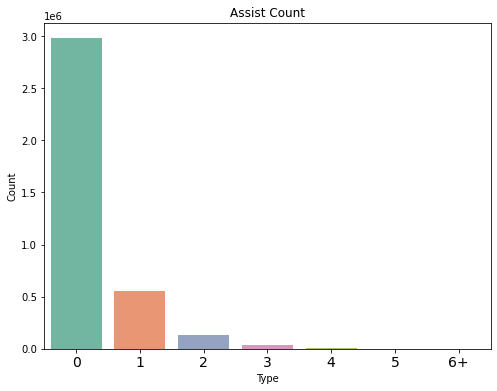

In [38]:
plt.figure(figsize=(8,6))
sns.barplot(x="Type", y="Count", data=train_ast, palette="Set2")
plt.xticks(fontsize=14)
plt.title("Assist Count")
plt.show()

- 대다수가 0에서 1 어시스트를 했다

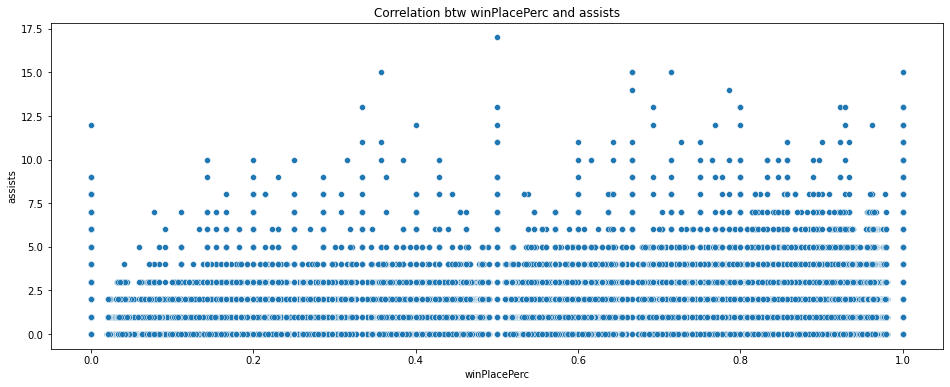

In [39]:
plt.figure(figsize=(16,6))
sns.scatterplot(data=train_group, x='winPlacePerc', y='assists')
plt.title("Correlation btw winPlacePerc and assists")
plt.show()

- 어시스트와 승리와의 뚜렷한 상관관계는 보이지 않는것 같다

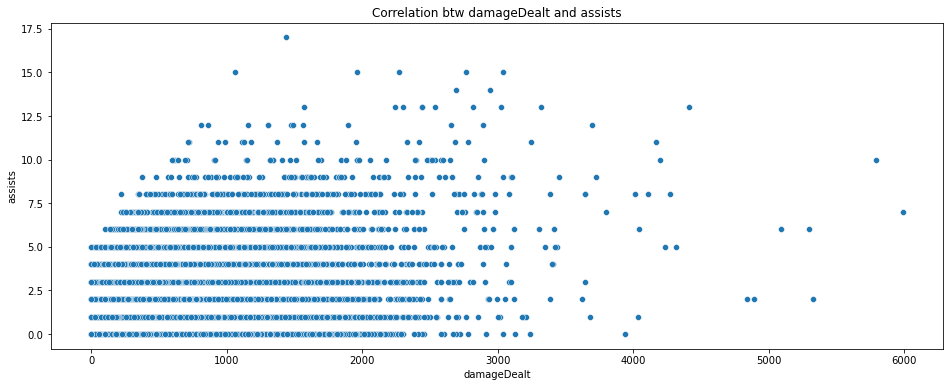

In [40]:
plt.figure(figsize=(16,6))
sns.scatterplot(data=train_group, x='damageDealt', y='assists')
plt.title("Correlation btw damageDealt and assists")
plt.show()

- 어시스트와 데미지와의 뚜렷한 상관관계는 보이지 않는것 같다

### DBNOS 

In [41]:
train_group['DBNOs'].quantile(0.999)

9.0

In [42]:
train_group.DBNOs.value_counts()

0     2046858
1      980807
2      394313
3      162429
4       69210
5       31645
6       14959
7        7282
8        3686
9        1962
10       1109
11        642
12        465
13        274
14        177
15        137
16         87
17         79
18         64
19         33
20         30
21         25
22         18
25         16
23         14
26         11
24         10
33          7
27          6
32          3
31          3
28          3
39          2
38          1
30          1
29          1
35          1
40          1
53          1
Name: DBNOs, dtype: int64

In [43]:
dbnos = train_group.copy()
dbnos.loc[dbnos['DBNOs'] >= 10] = '10+'
train_dbnos = dbnos.loc[:,"DBNOs"].value_counts().to_frame().reset_index()
train_dbnos.columns = ["Type","Count"]
train_dbnos

,Type,Count
0,0,2046858
1,1,980807
2,2,394313
3,3,162429
4,4,69210
5,5,31645
6,6,14959
7,7,7282
8,8,3686
9,10+,3221


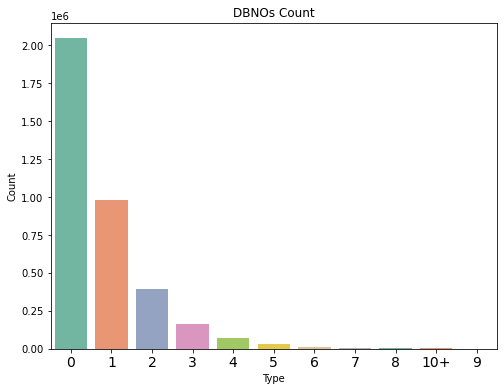

In [44]:
plt.figure(figsize=(8,6))
sns.barplot(x="Type", y="Count", data=train_dbnos, palette="Set2")
plt.xticks(fontsize=14)
plt.title("DBNOs Count")
plt.show()

In [45]:
train_group['DBNOs'].describe()

count   3716372.00000
mean          0.78564
std           1.21147
min           0.00000
25%           0.00000
50%           0.00000
75%           1.00000
max          53.00000
Name: DBNOs, dtype: float64

In [46]:
train_group['DBNOs'].mean()

0.7856420186138524

- 기절시킨 적의 평균수는 0.79이고, 대부분의 사람들이 기절도 못시켰다 

#### 기절과 킬이 연관이 있는지 알아보자

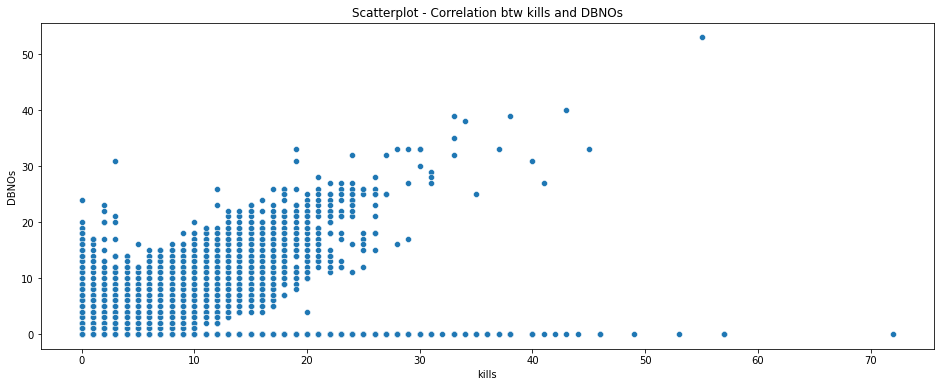

In [47]:
plt.figure(figsize=(16,6))
sns.scatterplot(data=train_group, x ="kills", y="DBNOs")
plt.title("Scatterplot - Correlation btw kills and DBNOs")
plt.show()

- 기절시킨 적의 수와 킬수간에는 양의 상관관계를 가진다
- 기절시킨 적의 수가 높을수록 킬로 마무리를 한것으로 보여진다

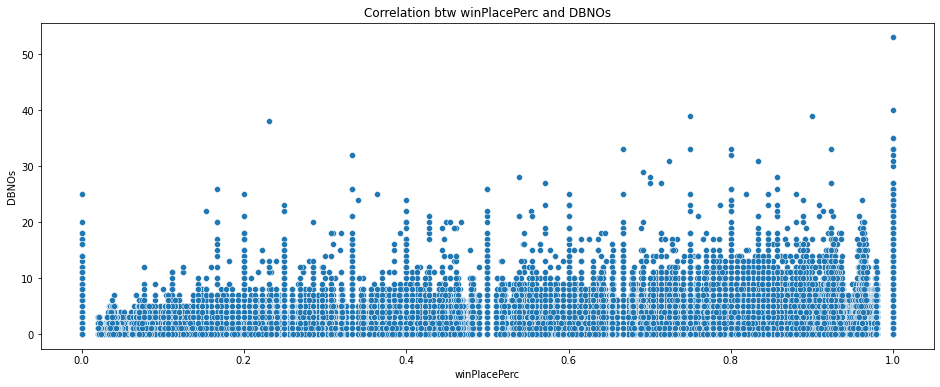

In [48]:
plt.figure(figsize=(16,6))
sns.scatterplot(data=train_group, x ="winPlacePerc", y="DBNOs")
plt.title("Correlation btw winPlacePerc and DBNOs")
plt.show()

- 기절시킨 적의 수와 승리간에는 어느정도 양의 상관관계를 가지는것 같다
- 대다수의 사람들이 기절도 못시켰던것으로 보인다 

### HeadshotKills

In [49]:
train['headshotKills'].quantile(0.999)

5.0

In [50]:
train['headshotKills'].value_counts()

0     3696115
1      574741
2      126348
3       32975
4        9962
5        3616
6        1439
7         757
8         373
9         215
10        136
11         79
12         64
13         44
14         23
15         16
16         15
17         11
18          9
19          3
23          3
20          3
26          3
31          2
34          2
27          2
21          2
41          1
64          1
40          1
39          1
46          1
42          1
35          1
Name: headshotKills, dtype: int64

In [51]:
headshot = train.copy()
headshot.loc[headshot['headshotKills'] >= 4] = '4+'
train_headshot = headshot.loc[:,"headshotKills"].value_counts().to_frame().reset_index()
train_headshot.columns = ["Type","Count"]
train_headshot

,Type,Count
0,0,3696115
1,1,574741
2,2,126348
3,3,32975
4,4+,16786


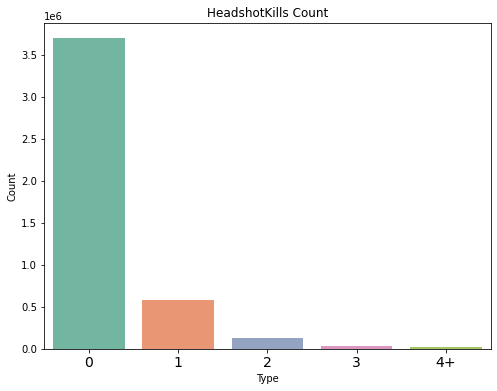

In [52]:
plt.figure(figsize=(8,6))
sns.barplot(x="Type", y="Count", data=train_headshot, palette="Set2")
plt.xticks(fontsize=14)
plt.title("HeadshotKills Count")
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

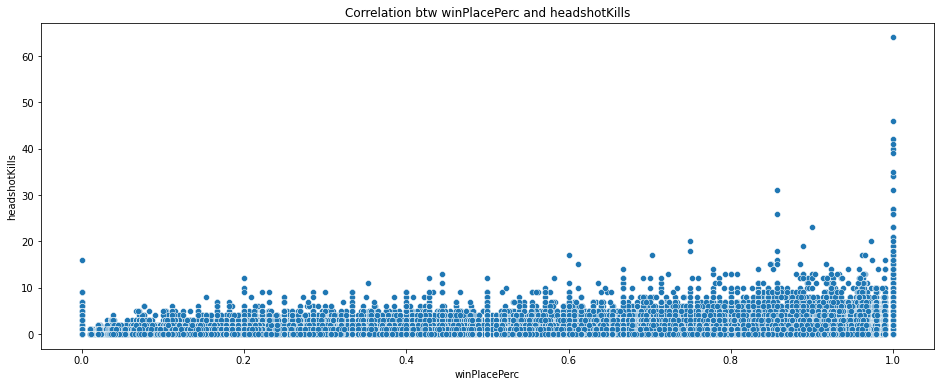

In [53]:
plt.figure(figsize=(16,6))
sns.scatterplot(data=train, x="winPlacePerc", y="headshotKills", palette="Set2")
plt.title("Correlation btw winPlacePerc and headshotKills")
plt.show

- 뚜렷한 상관관계는 보이지 않는다

### Longestkill

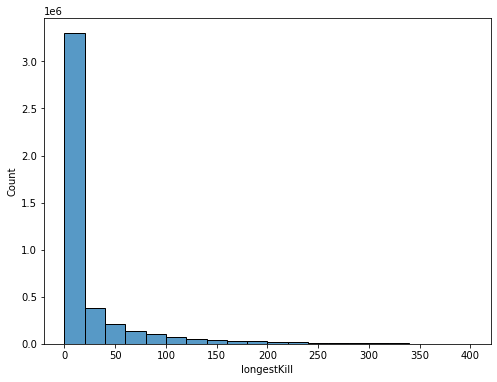

In [54]:
range = train[train['longestKill']<400]
plt.figure(figsize=(8,6))
sns.histplot(data=range, x='longestKill', bins=20)
plt.show()

In [55]:
train['longestKill'].describe()

count   4446965.00000
mean         22.99760
std          50.97262
min           0.00000
25%           0.00000
50%           0.00000
75%          21.32000
max        1094.00000
Name: longestKill, dtype: float64

In [56]:
train[train['longestKill'] == 0 & (train['kills'] > 0)]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00000,0,0,0,60,...,0,0.00000,0,0.00000,0,0,244.80000,1,1466,0.44440
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47000,0,0,0,57,...,0,0.00450,0,11.04000,0,0,1434.00000,5,0,0.64000
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00000,0,0,0,47,...,0,0.00000,0,0.00000,0,0,161.80000,2,0,0.77550
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90000,0,0,0,75,...,0,0.00000,0,0.00000,0,0,202.70000,3,0,0.16670
6,95959be0e21ca3,2c485a1ad3d0f1,a8274e903927a2,0,0,0.00000,0,0,0,96,...,0,0.00000,0,0.00000,0,0,13.50000,1,1497,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4446958,837349af7e8a35,58bc4104935623,2001300d4f5787,0,0,0.00000,0,0,0,92,...,0,0.00000,0,0.00000,0,0,0.00000,0,0,0.00000
4446959,d29bfa313ad766,ac3f1b4a56e5ad,2f3b1af94739b3,0,0,22.68000,0,0,0,89,...,0,0.00000,0,0.00000,0,0,40.25000,1,0,0.08420
4446961,afff7f652dbc10,d238e426f50de7,18492834ce5635,0,0,0.00000,0,0,0,74,...,0,1292.00000,0,0.00000,0,0,1019.00000,3,1507,0.17860
4446962,f4197cf374e6c0,408cdb5c46b2ac,ee854b837376d9,0,1,44.15000,0,0,0,69,...,0,0.00000,0,0.00000,0,0,81.70000,6,0,0.29350


- 킬을 할때까지 최대의 거리는 1094m이다
- 킬을 할때까지 거리의 평균은 23m이다
- 킬을 할때까지 거리가 0인 값들은 
    - nan값을 0으로 전처리 해줬을 가능성이 있다
    - 아니면 커스텀 매치일수도 있다

### KIllStreaks

In [57]:
train['killStreaks'].quantile(0.999)

4.0

In [58]:
train['killStreaks'].value_counts()

0     2529721
1     1475558
2      389346
3       45958
4        5711
5         409
6         126
7          54
8          32
9          18
10          9
11          8
13          5
12          5
14          2
16          1
18          1
20          1
Name: killStreaks, dtype: int64

In [59]:
streaks = train.copy()
streaks.loc[streaks['killStreaks'] >= 5] = '5+'
train_streaks = streaks.loc[:,"killStreaks"].value_counts().to_frame().reset_index()
train_streaks.columns = ["Type","Count"]
train_streaks

,Type,Count
0,0,2529721
1,1,1475558
2,2,389346
3,3,45958
4,4,5711
5,5+,671


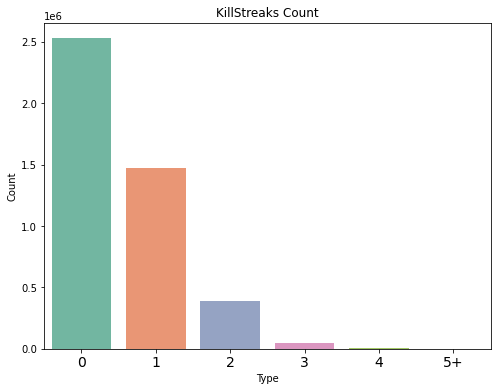

In [60]:
plt.figure(figsize=(8,6))
sns.barplot(x="Type", y="Count", data=train_streaks, palette="Set2")
plt.xticks(fontsize=14)
plt.title("KillStreaks Count")
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

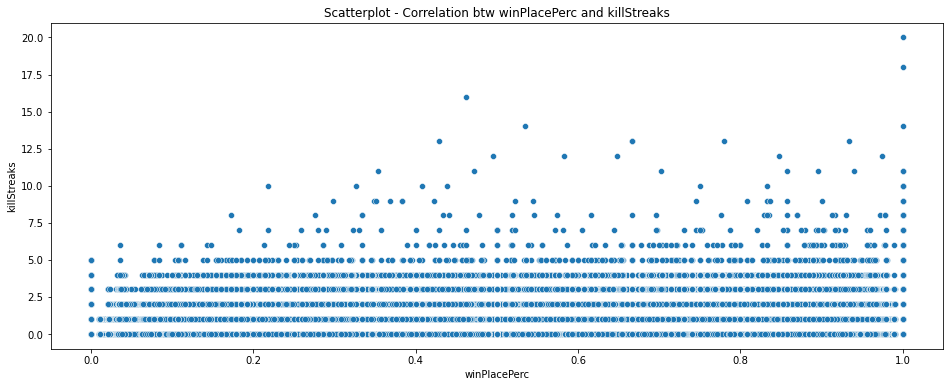

In [61]:
plt.figure(figsize=(16,6))
sns.scatterplot(data=train, x="winPlacePerc", y="killStreaks", palette="Set2")
plt.title("Scatterplot - Correlation btw winPlacePerc and killStreaks")
plt.show

- 짧은 시간내에 적을 죽인 수가 많을수록 승리할 확률이 높아지는것 같다 

### teamKills

In [62]:
train_group['teamKills'].quantile(0.999)

2.0

In [63]:
train_group['teamKills'].value_counts()

0     3628318
1       79933
2        7203
3         826
4          80
5           6
10          2
7           1
12          1
6           1
8           1
Name: teamKills, dtype: int64

In [64]:
teamKills = train.copy()
teamKills.loc[teamKills['teamKills'] >= 3] = '3+'
train_tks= teamKills.loc[:,"teamKills"].value_counts().to_frame().reset_index()
train_tks.columns = ["Type","Count"]
train_tks

,Type,Count
0,0,4350035
1,1,88771
2,2,7236
3,3+,923


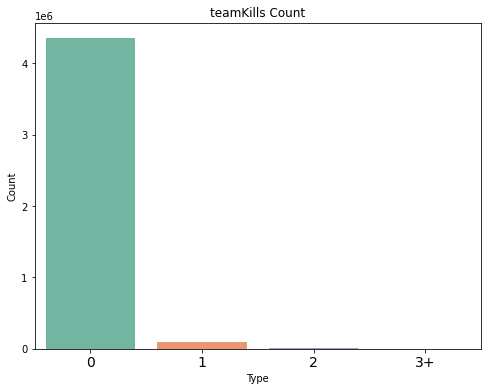

In [65]:
plt.figure(figsize=(8,6))
sns.barplot(x="Type", y="Count", data=train_tks, palette="Set2")
plt.xticks(fontsize=14)
plt.title("teamKills Count")
plt.show()

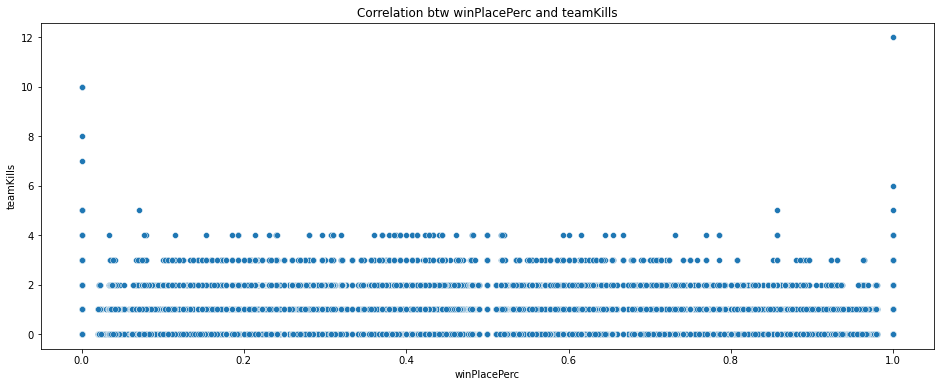

In [66]:
plt.figure(figsize=(16,6))
sns.scatterplot(data=train_group, x='winPlacePerc', y='teamKills')
plt.title("Correlation btw winPlacePerc and teamKills")
plt.show()

- teamkill의 수가 거의 없어서 승리와의 상관관계는 없다고 보여진다

### Heals & Boosts

<AxesSubplot:xlabel='boosts', ylabel='count'>

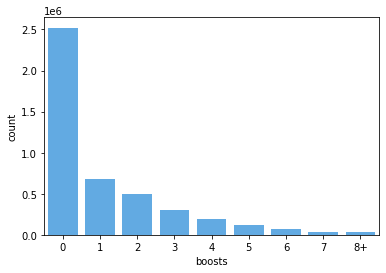

In [67]:
tmpd = train.copy()
tmpd.loc[tmpd.boosts>tmpd.boosts.quantile(0.99)]="8+"
sns.countplot(x=tmpd.boosts.astype(str).sort_values(), data=tmpd, color='#4dadf7')

- 부스트 아이템의 사용율은 그리 높지 않음을 확인할 수 있다. 숙련도 문제이건, 파밍 문제이건 간에 아이템을 써보지도 못하고 죽는 유저가 많다.

#### 힐과 부스트의 갯수와 승리와의 상관관계

In [68]:
heals = train['heals'].quantile(0.999)
boosts = train['boosts'].quantile(0.999)
print(heals, boosts)

22.0 10.0


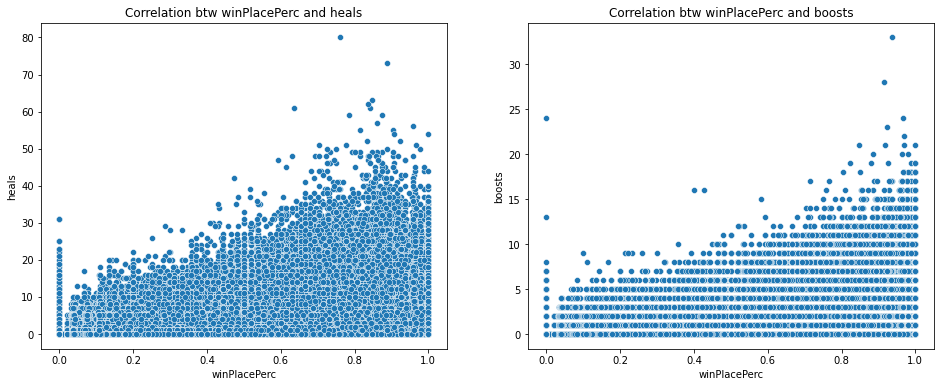

In [69]:
plt.figure(figsize=(16,6))
plt.subplot(121)
sns.scatterplot(data=train, x='winPlacePerc', y='heals')
plt.title("Correlation btw winPlacePerc and heals")
plt.subplot(122)
sns.scatterplot(data=train, x='winPlacePerc', y='boosts')
plt.title("Correlation btw winPlacePerc and boosts")
plt.show()

In [70]:
train[['heals', 'boosts']].describe()

,heals,boosts
count,4446965.00000,4446965.00000
mean,1.37015,1.10691
std,2.67998,1.71579
min,0.00000,0.00000
25%,0.00000,0.00000
50%,0.00000,0.00000
75%,2.00000,2.00000
max,80.00000,33.00000


- Heals와 boosts 모두 승리와의 양의 상관관계를 보인다
- 부스트 아이템을 쓰는 유저는 최소한의 숙련/파밍이 이루어진 유저로 볼 수 있다
- Heals 평균 사용 횟수는 1.3이고, 대다수의 사람들이 하나도 사용하지 못했다 
- Boosts 평균 사용 횟수는 1.1이고, 대다수의 사람들이 하나도 사용하지 못했다
- 이는, 시작하자 마자 죽은 사람이 대다수라서 아이템들을 사용할 기회가 없었던 것으로 예상된다

#### 힐과 부스트의 갯수와 움직인 거리 (walkDistance + rideDistance + swimDistance)

In [71]:
train['totalDistance'] = train.walkDistance + train.rideDistance + train.swimDistance
train['totalDistance'].value_counts()

0.00000       97369
0.28000         912
101.50000       612
110.10000       595
101.20000       593
              ...  
6513.05000        1
543.37000         1
2510.10500        1
3632.96200        1
790.88400         1
Name: totalDistance, Length: 338781, dtype: int64

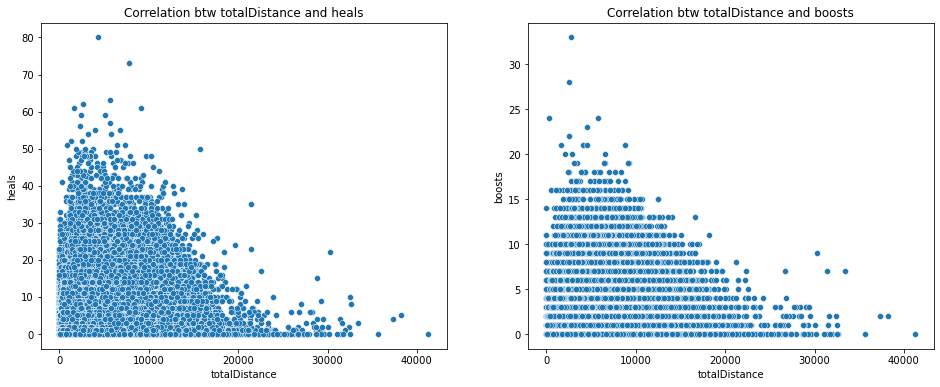

In [72]:
plt.figure(figsize=(16,6))
plt.subplot(121)
sns.scatterplot(data=train, x='totalDistance', y='heals')
plt.title("Correlation btw totalDistance and heals")
plt.subplot(122)
sns.scatterplot(data=train, x='totalDistance', y='boosts')
plt.title("Correlation btw totalDistance and boosts")
plt.show()

- 힐과 부스트 아이템들과 움직인 거리 간에는 음의 상관관계를 보인다 
- 많이 움직일수록 힐과 부스트 사용 갯수는 오히려 떨어지는 것으로 보인다

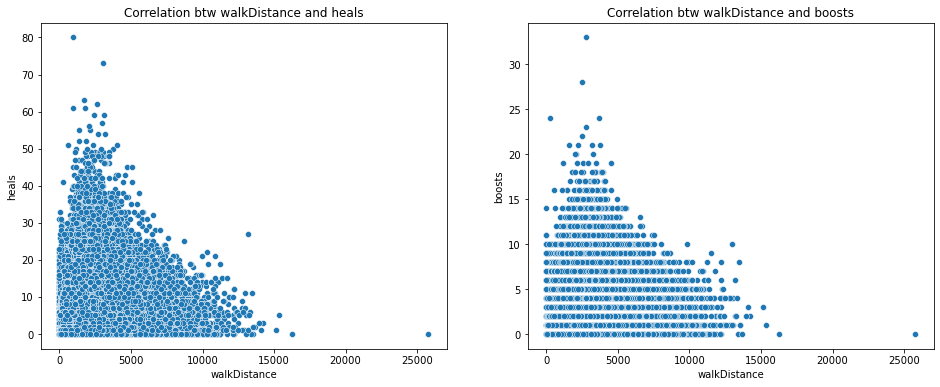

In [73]:
plt.figure(figsize=(16,6))
plt.subplot(121)
sns.scatterplot(data=train, x='walkDistance', y='heals')
plt.title("Correlation btw walkDistance and heals")
plt.subplot(122)
sns.scatterplot(data=train, x='walkDistance', y='boosts')
plt.title("Correlation btw walkDistance and boosts")
plt.show()

#### 힐과 부스트의 사용갯수와 킬과 연관된 feature들과의 관계

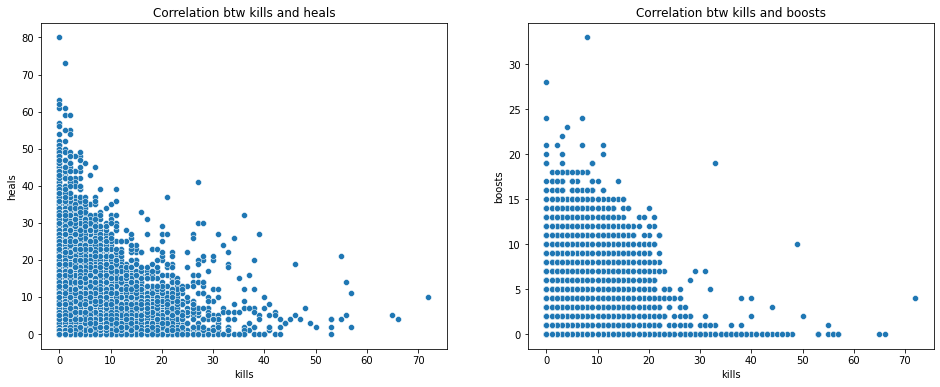

In [74]:
plt.figure(figsize=(16,6))
plt.subplot(121)
sns.scatterplot(data=train, x='kills', y='heals')
plt.title("Correlation btw kills and heals")
plt.subplot(122)
sns.scatterplot(data=train, x='kills', y='boosts')
plt.title("Correlation btw kills and boosts")
plt.show()

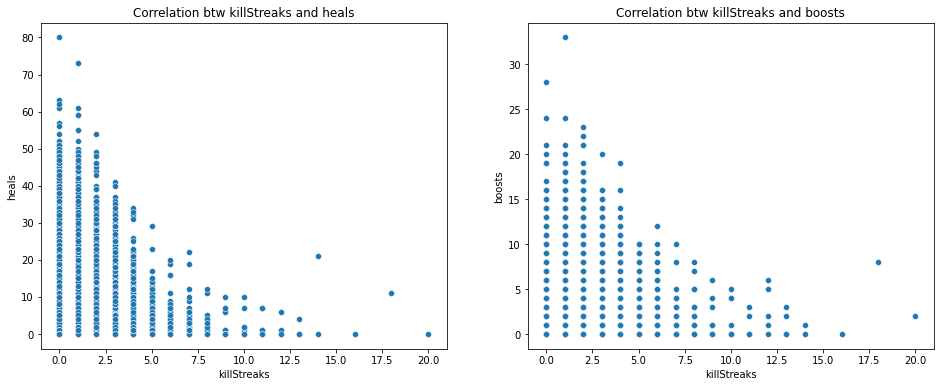

In [75]:
plt.figure(figsize=(16,6))
plt.subplot(121)
sns.scatterplot(data=train, x='killStreaks', y='heals')
plt.title("Correlation btw killStreaks and heals")
plt.subplot(122)
sns.scatterplot(data=train, x='killStreaks', y='boosts')
plt.title("Correlation btw killStreaks and boosts")
plt.show()

- 킬수와 연속으로 적을 죽인 킬수가 높아질수록 힐, 부스트 사용횟수는 떨어진다 

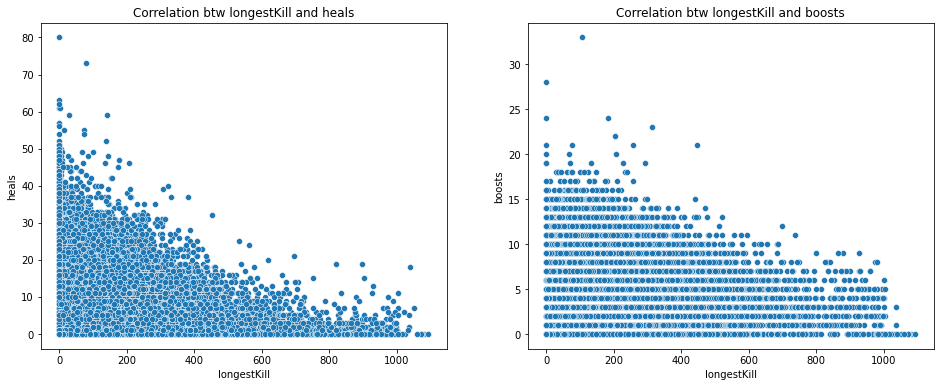

In [76]:
plt.figure(figsize=(16,6))
plt.subplot(121)
sns.scatterplot(data=train, x='longestKill', y='heals')
plt.title("Correlation btw longestKill and heals")
plt.subplot(122)
sns.scatterplot(data=train, x='longestKill', y='boosts')
plt.title("Correlation btw longestKill and boosts")
plt.show()

- 거리가 멀수록 힐과 부스트의 사용갯수가 떨어진다 

In [77]:
help = train[['heals', 'winPlacePerc']].groupby(train['boosts']).mean()
help

,heals,winPlacePerc
boosts,,
0,0.25978,0.30132
1,1.68597,0.56102
2,2.46587,0.68215
3,3.38155,0.77617
4,3.99670,0.83125
5,4.54125,0.86794
6,4.99019,0.89476
7,5.34822,0.91536
8,5.65204,0.92850


- 1개 이상부터 반 이상의 관계를 보여주며 급격히 높아지는걸 확인 할 수 있다. 
- 따라서, boosts아이템과는 관계가 아주 높다고 보여진다.
- 다만, 밑에서 세번째 row의 경우 주변과 다르게 매우 낮은수치인것을 확인할 수 있다

In [78]:
train[train.boosts == 24]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,totalDistance
1465177,1d85e9f3c46f1a,922edc8b32c161,0b5bd195ccd136,0,24,746.30000,0,4,1,2,...,2175.00000,0,0.00000,0,0,3650.00000,4,1562,0.96630,5825.00000
3979434,d16b329d5ea64f,ba50388b7256f1,57770aadb2235b,0,24,0.00000,0,0,1,4,...,0.00000,0,0.00000,0,0,267.30000,8,0,0.00000,267.30000


- 아주 높은구간에서 특이하게 반 이하로 떨어진 승률을 확인해 보니, 2개중 1개는 높지만 한개가 0으로 평균값때문에 떨어진걸로 확인된다. 

추가적으로 첫번째 row는 왜이렇게 낮은지 확인해 보자

<AxesSubplot:xlabel='winner', ylabel='count'>

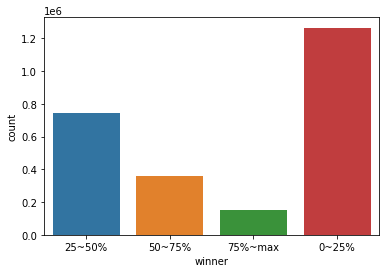

In [79]:
boo = train[train.boosts == 0]
# boo # 2521323
boo[['boosts', 'winPlacePerc']].winPlacePerc.describe() /10
'''
count    252132.300000
mean          0.030132
std           0.024268
min           0.000000
25%           0.010420
50%           0.025000
75%           0.045650
max           0.100000
'''


def func(x):
    if x <= 0.25:
        return '0~25%'
    elif x <= 0.5:
        return '25~50%'
    elif x <= 0.75:
        return '50~75%'
    else:
        return '75%~max'

boo['winner'] = boo['winPlacePerc'].map(func)

boo1 = boo.winner.value_counts() #.plot.bar()

sns.countplot('winner', data=boo)

- 위에서도 확인했듯이 매우 높은 분포와 분포내에서 낮은 승률을 보여지고 있는것으로 확인된다

- 따라서 지금까지 확인되는것으로는 walkDistance와 boosts가 가장 관계가 높았으며, 그 이후로는 kill로 확인된다


### walkDistance

<Figure size 1152x432 with 0 Axes>

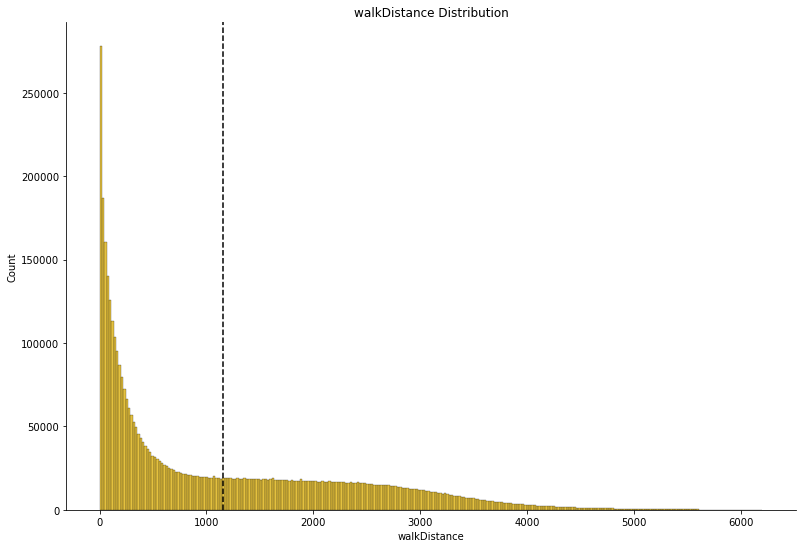

In [80]:
plt.figure(figsize=(16,6))
sns.displot(train[train.walkDistance<train.walkDistance.quantile(0.999)].walkDistance, height=7.5, aspect=1.5, color="#dbac00")
plt.axvline(train.walkDistance.mean(), color="black", linestyle="--")
#plt.xticks(range(0,4500,250))
plt.title("walkDistance Distribution")
plt.show()

극단값 포함 평균이 1180 근처에서 형성되는 것을 볼 수 있으며, 대부분의 조기 탈락자가 먼 길을 가지 못했음을 확인 가능

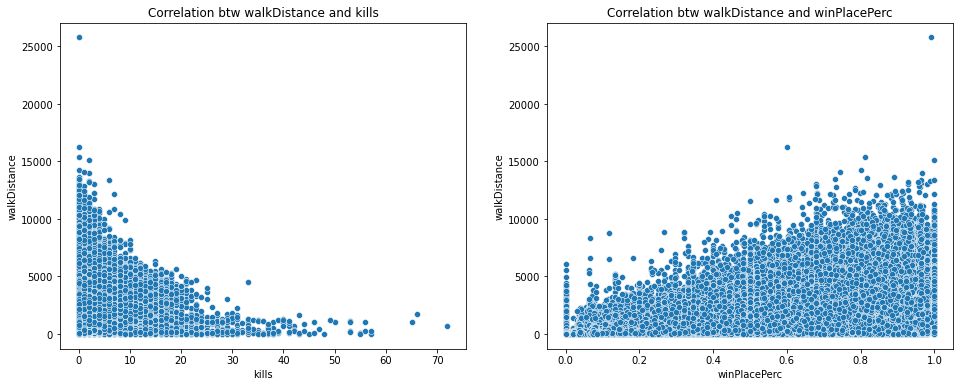

In [81]:
plt.figure(figsize=(16,6))
plt.subplot(121)
sns.scatterplot(data=train, x='kills', y='walkDistance')
plt.title("Correlation btw walkDistance and kills")
plt.subplot(122)
sns.scatterplot(data=train, x='winPlacePerc', y='walkDistance')
plt.title("Correlation btw walkDistance and winPlacePerc")
plt.show()

- 걸은 거리가 많을수록 킬수가 높은것만은 아닌것으로 보여진다
- 오히려 걸은 거리가 적은 사람들중에 킬수가 많은 사람들이 많은 것으로 보여진다
- 걸은 거리와 승률과의 관계에서는 양의 상관관계를 보인다

In [82]:
train[train['walkDistance'] > 20000][['maxPlace','matchType', 'walkDistance', 'swimDistance', 'rideDistance', 'winPlacePerc']]

,maxPlace,matchType,walkDistance,swimDistance,rideDistance,winPlacePerc
497965,95,solo-fpp,25780.00000,381.90000,0.00780,0.98940


- 걸은 거리가 25780.0인 사람은 걷거나 수영만 했고 아이템을 파밍하지도 않았고 아무도 안만나서 데미지도 없는 것으로 보아 맵탐방을 하지 않았을까 예상이된다 
- 그럼에도 불구하고 승리는 못했지만 높은 등수를 차지한것으로 보인다

#### 이동하지 않았는데 아이템을 획득한 사람들

In [83]:
train[(train.walkDistance == 0) & (train.weaponsAcquired != 0)][['walkDistance', 'weaponsAcquired', 'damageDealt', 'kills']]

,walkDistance,weaponsAcquired,damageDealt,kills
711,0.00000,1,0.00000,0
846,0.00000,6,0.00000,0
1357,0.00000,15,722.80000,0
1433,0.00000,1,85.60000,0
1814,0.00000,1,0.00000,0
...,...,...,...,...
4446464,0.00000,1,0.00000,0
4446682,0.00000,4,41.95000,1
4446786,0.00000,1,0.00000,0
4446812,0.00000,1,0.00000,0


In [84]:
train['matchType'].value_counts()

squad-fpp           1756186
duo-fpp              996691
squad                626526
solo-fpp             536761
duo                  313591
solo                 181943
normal-squad-fpp      17174
crashfpp               6287
normal-duo-fpp         5489
flaretpp               2505
normal-solo-fpp        1682
flarefpp                718
normal-squad            516
crashtpp                371
normal-solo             326
normal-duo              199
Name: matchType, dtype: int64

In [85]:
train[(train.walkDistance == 0) & (train.kills > 1)][['maxPlace', 'matchType', 'walkDistance', 'weaponsAcquired', 'damageDealt', 'kills']]

,maxPlace,matchType,walkDistance,weaponsAcquired,damageDealt,kills
1824,15,normal-squad-fpp,0.00000,8,593.00000,6
6673,11,normal-squad-fpp,0.00000,22,346.60000,3
11892,20,normal-solo-fpp,0.00000,13,1750.00000,20
20881,6,normal-squad,0.00000,8,506.10000,6
23298,6,normal-squad-fpp,0.00000,8,1124.00000,12
...,...,...,...,...,...,...
4429697,6,normal-squad-fpp,0.00000,31,645.60000,5
4436511,6,normal-squad-fpp,0.00000,8,221.60000,5
4437516,14,normal-squad-fpp,0.00000,24,361.70000,5
4440927,11,normal-squad-fpp,0.00000,7,909.10000,6


- 이사람들은 불법 프로그램 사용자들일까?
- 낙하산에서 내리자마자 그자리에 아이템이 있어서 먹을 수도 있지만, 움직이지도 않고 킬을 여러개(1킬이상) 한것은 의심스러워 보인다 
- 이상치로 제거를 해야할것 같다

### swimDistance

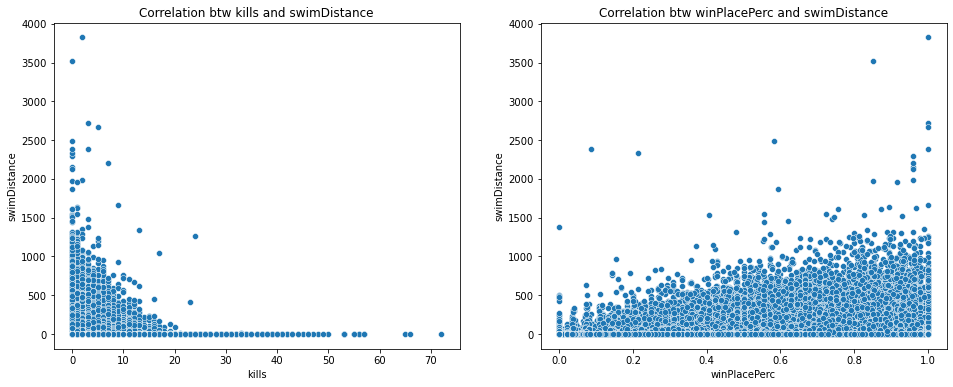

In [86]:
plt.figure(figsize=(16,6))
plt.subplot(121)
sns.scatterplot(data=train, x='kills', y='swimDistance')
plt.title("Correlation btw kills and swimDistance")
plt.subplot(122)
sns.scatterplot(data=train, x='winPlacePerc', y='swimDistance')
plt.title("Correlation btw winPlacePerc and swimDistance")
plt.show()

- 수영한 거리와 킬과의 상관관계는 음의 상관관계를 가진다
- 수영한 거리와 승리와의 상관관계는 양의 상관관계를 가진다 

### rideDistance

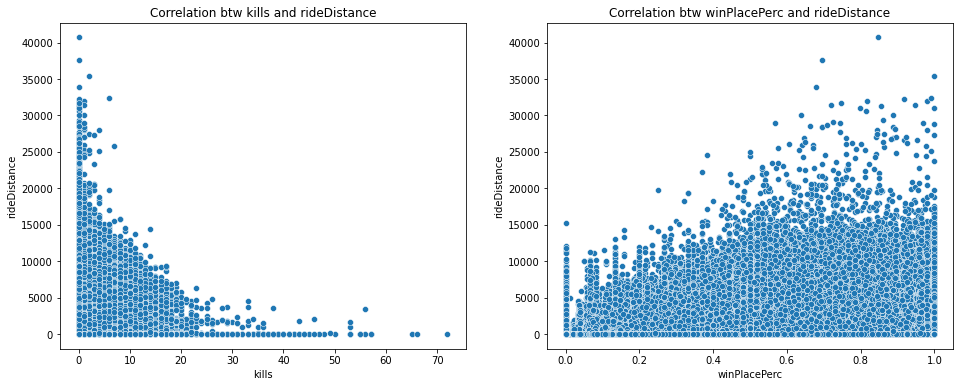

In [87]:
plt.figure(figsize=(16,6))
plt.subplot(121)
sns.scatterplot(data=train, x='kills', y='rideDistance')
plt.title("Correlation btw kills and rideDistance")
plt.subplot(122)
sns.scatterplot(data=train, x='winPlacePerc', y='rideDistance')
plt.title("Correlation btw winPlacePerc and rideDistance")
plt.show()

- 이동수단으로 이동한 거리와 킬과의 상관관계는 음의 상관관계를 가진다
- 이동수단으로 이동한 거리와 승리와의 상관관계는 양의 상관관계를 가진다 

#### 이동과 관련된 feature들과 승리와의 관계

In [88]:
train[['rideDistance', 'swimDistance', 'walkDistance', 'winPlacePerc']].corr()

,rideDistance,swimDistance,walkDistance,winPlacePerc
rideDistance,1.00000,0.04945,0.31094,0.34291
swimDistance,0.04945,1.00000,0.16751,0.14961
walkDistance,0.31094,0.16751,1.00000,0.81089
winPlacePerc,0.34291,0.14961,0.81089,1.00000


- 이동과 관련된 feature들 중에서 걸어가는게 제일(매우) 관계가 높은것으로 보아 다른 이동수단 보다는 걸어가는것이 승리에 더욱 용이하다고 추론할 수 있다

- 다음으로 안전하다고 볼수 있는건 탈것을 통해서 이동할때, 그다음 상대적으로 제일 위험하다고 볼수 있는 '수영' 순이다

### weaponsAcquired

In [89]:
df.weaponsAcquired.quantile(0.5)

5.0

<AxesSubplot:xlabel='weaponsAcquired', ylabel='count'>

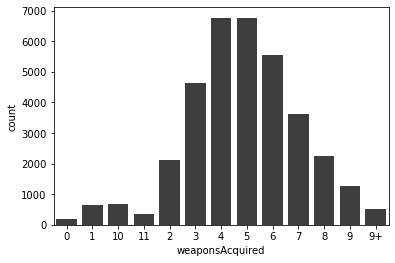

In [90]:
tmpd = df.copy()
tmpd.loc[tmpd.weaponsAcquired>tmpd.weaponsAcquired.quantile(0.98)]="9+"
sns.countplot(x=tmpd.weaponsAcquired.astype(str).sort_values(), data=tmpd, color='#3b3e40')

평균적으로 3개씩의 무기를 주웠으며, 더 큰 수치로 갈 수록 비율이 줄어드는건 이전 지표와 같으나 적어도 무기를 하나는 먹은 사람이 많음을 확인할 수 있음.

#### 얻은 무기의 수와 생존(승률)과 연관이 있는지 알아보자

<AxesSubplot:ylabel='weaponsAcquired'>

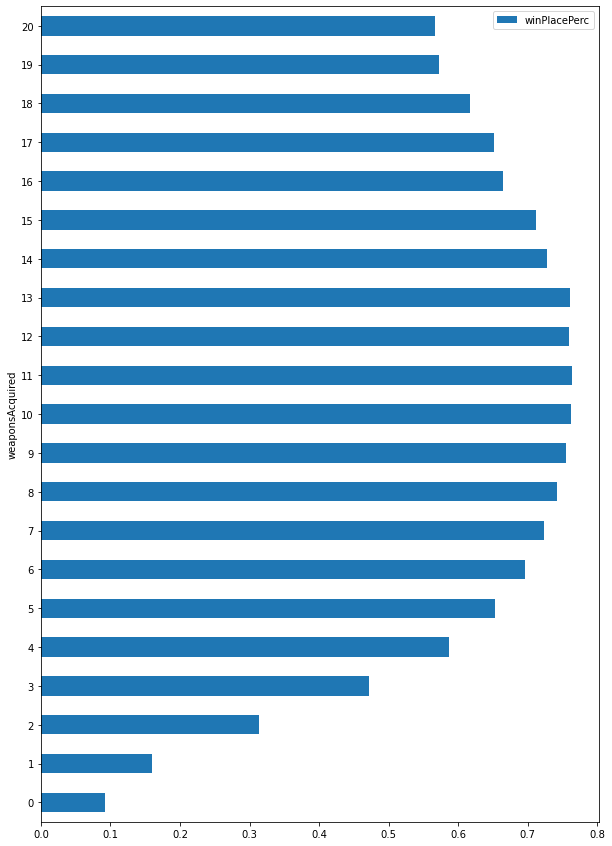

In [91]:
# 15개 이하의 데이터 취합, target(생존/승률) 평균치
wl = train[train.weaponsAcquired <= 20]
how = {
    "winPlacePerc" : np.mean
}
wl = wl.groupby('weaponsAcquired').agg( how )
# wl
fig = plt.figure(figsize=(10 ,15))
graph1 = fig.add_subplot(1,1,1)


wl.plot.barh(ax=graph1)

- 무기를 일정 기준치(약 4 ~ 18) 얻을 경우 승률이 올라가는걸 확인할 수 있다
- 승률이 올라간 기준치에서 추가적으로 데미지도 많이 줬는지 알아보자

In [92]:
from pandas.core.groupby import groupby
# train[train.weaponsAcquired <= 15].damageDealt.value_counts()
b = train[(train.weaponsAcquired <= 20) & (train.weaponsAcquired >= 5)]
weapons_dmg = b[['damageDealt', 'winPlacePerc']].groupby(b['weaponsAcquired']).mean()
weapons_dmg

,damageDealt,winPlacePerc
weaponsAcquired,,
5,176.10252,0.65352
6,193.10940,0.69656
7,204.98188,0.72319
8,212.47524,0.74163
9,217.75265,0.75482
10,219.08369,0.76148
11,217.72166,0.76416
12,226.92775,0.75942
13,234.56449,0.76129


- 일정 기준치 안에서 16개 이상일때부터 총 넣은 데미지가 급격하게 늘어났으나, 승률은 그전(15개 이하)이 더 좋은걸 확인할 수 있다.

<AxesSubplot:xlabel='Damage'>

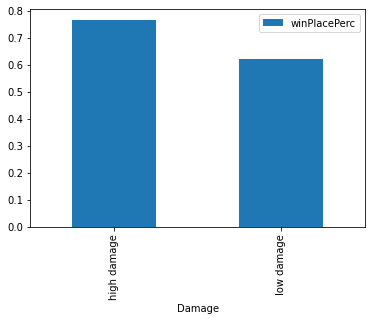

In [93]:
b.damageDealt.describe() # 중앙값 132
b[b.damageDealt <= 132]

def func(x):
    if x <= 132:
        return "low damage"
    else:
        return "high damage"

b['Damage'] = b['damageDealt'].map(func)

how = {
    "winPlacePerc" : np.mean
}
t = b.groupby('Damage').agg( how )
t.plot.bar()

- 그렇지만 무기 습득 개수와 별개로 high damage가 상대적으로 target과 연관이 있다는걸 확인할 수 있다

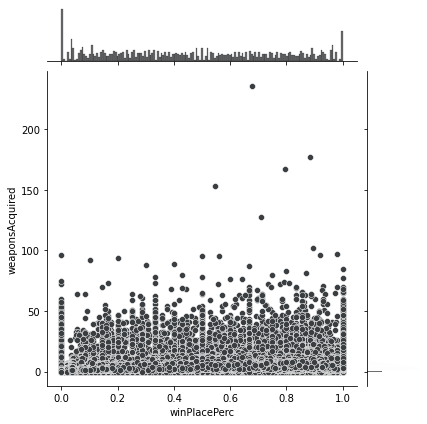

In [94]:
sns.jointplot(x="winPlacePerc", y="weaponsAcquired", data=train, color="#3b3e40")

하지만 다른 지표들과는 다르게, jointPlot에서 뚜렷한 양의 상관관계가 나타나지는 않는 것으로 보인다. 어째서일까?

가설 1 : 0과 1+의 차이가 중요해서 그렇다. 


가설 2 : 50+ 이상의 outlier가 결과 도출을 방해해서 그렇다.

In [95]:
train[["winPlacePerc","weaponsAcquired"]].corr() #원본

,winPlacePerc,weaponsAcquired
winPlacePerc,1.00000,0.58381
weaponsAcquired,0.58381,1.00000


In [96]:
idkdata = train.loc[train.weaponsAcquired!=0]   #무기를 주운 사람만 계산시?  
idkdata[["weaponsAcquired","winPlacePerc"]].corr()
#단순히 무기를 집었다/아니다 이상의 의미가 큼

,weaponsAcquired,winPlacePerc
weaponsAcquired,1.00000,0.54300
winPlacePerc,0.54300,1.00000


In [97]:
tmpd = train.copy()    #이상치 처리
tmpd.loc[tmpd.weaponsAcquired>tmpd.weaponsAcquired.quantile(0.98), "weaponsAcquired"]=9
tmpd[["winPlacePerc","weaponsAcquired"]].corr()

,winPlacePerc,weaponsAcquired
winPlacePerc,1.00000,0.63120
weaponsAcquired,0.63120,1.00000


- 결과: 무기를 주운 사람만 놓고 상관계수를 보아도 여전히 54%의 상관관계를 보이는 것으로 보아, 주운 무기 숫자가 오히려 무기 습득 여부보다 중요했음을 알 수 있다.
- 또한, 습득한 무기가 9개 이상인 사람들을 조정하고 상관관계 계산 시 수치가 63%로 오르는 것으로 보아, 이상치가 예측을 꽤 방해하고 있는 것으로 보인다.

- 아이템 획득수와 킬 또는 승리와의 뚜렷한 상관관계는 보이지 않는다

#### 무기없이 주먹으로 킬한 사람들

In [98]:
train[(train.weaponsAcquired == 0) & (train.kills != 0)]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,totalDistance
1627,374cc8a5be8b70,e5100ca55f36ad,9a70b0ea4aeb41,0,0,100.00000,1,0,0,38,...,0.00000,0,0.00000,0,0,45.97000,0,1521,0.32140,45.97000
3946,5147d333d6e97e,5574058360a44d,04de3bdc8540a7,0,0,100.00000,0,0,0,43,...,0.00000,0,0.00000,0,0,32.92000,0,0,0.17710,32.92000
7259,bb8858aefdb39b,6497251ef13d14,681b7e6ea05b36,0,0,200.00000,5,2,0,14,...,259.20000,0,0.00000,3,0,177.30000,0,0,0.12000,436.50000
7559,e7f6ddcdf8ca71,2f0765e8468ca3,493f437b8ff573,0,0,100.00000,1,0,0,37,...,0.00000,0,0.00000,0,0,116.70000,0,0,0.08330,116.70000
8103,438b9a42334ae7,90106304ecb514,9541d38c78fa96,0,0,100.00000,1,1,0,43,...,0.00000,0,0.00000,0,0,25.54000,0,0,0.02130,25.54000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4441281,6bcc98a777c5e3,8c759f7e84c7d0,ed5d47d80ac351,0,0,300.00000,2,0,0,4,...,7771.00000,3,0.00000,0,0,125.90000,0,0,0.91490,7896.90000
4444332,21f2f6fbbfe07f,05e2272d9d21b6,e31dadd8f4ca23,0,0,100.00000,1,1,0,37,...,0.00000,0,0.00000,0,0,4.26600,0,1500,0.02080,4.26600
4444788,9ecceeee4c22d8,83cf390fe9ec21,aa6a6a2264ec4b,0,0,100.00000,1,0,0,29,...,1286.00000,1,0.00000,0,0,154.20000,0,0,0.50000,1440.20000
4445403,938c987197a2f3,726c62fce70a0d,4fdab3b35454bd,0,0,11.60000,1,0,0,33,...,0.00000,0,0.00000,0,0,256.50000,0,0,0.12000,256.50000


In [99]:
print(len(train[(train.weaponsAcquired == 0) & (train.kills != 0)]))

3310


- 무기를 획득하지 않고 kill수를 획득한 사람들(3310)은 주먹으로 싸워서 이긴것 같다 

### killPlace : 처치 순위, 전투와 관련된 지표

- 하지만 matchid에 따라 winPlacePerc과 정렬되는 것으로 확인. 제외하고 분석할 지는 미정* 

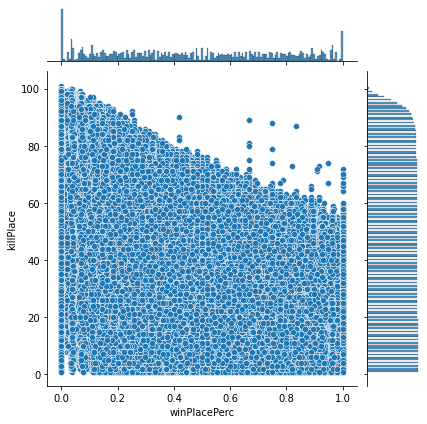

In [100]:
sns.jointplot(x="winPlacePerc", y="killPlace", data=train)

순위에 따라 음의 상관관계를 보이는 것으로 확인되나, 킬 순위가 높다고 해서 무조건 승률로 이어지는 것은 아닌 것으로 보인다.



다만 킬 순위는 개인별로 집계되는 것으로 보아 그룹과 솔로 게임에서의 정확도가 다르게 나타날 수도 있다.

<AxesSubplot:xlabel='killPlace', ylabel='Count'>

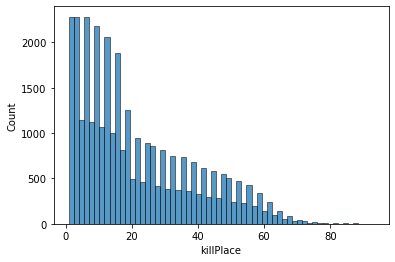

In [101]:
sns.histplot(train[train.maxPlace<20].killPlace)

또한 자체 정원이 적은 사설방의 경우에도 킬 등수가 비정상적으로 분포하는 걸 확인할 수 있다. 방 인원수에 따라 등수를 정규화할 필요가 있을 수도 있다.

- #### 이상치 탐색 : 과도할 정도의 아이템을 습득한 경우, 이동 거리가 0인데 수많은 아이템을 획득한 경우 등

data를 직접 확인한 결과, 공통적으로 maxPlace 수치가 이상하다는 것을 발견함.

<AxesSubplot:title={'center':'maxPlace Distribution'}, xlabel='maxPlace', ylabel='count'>

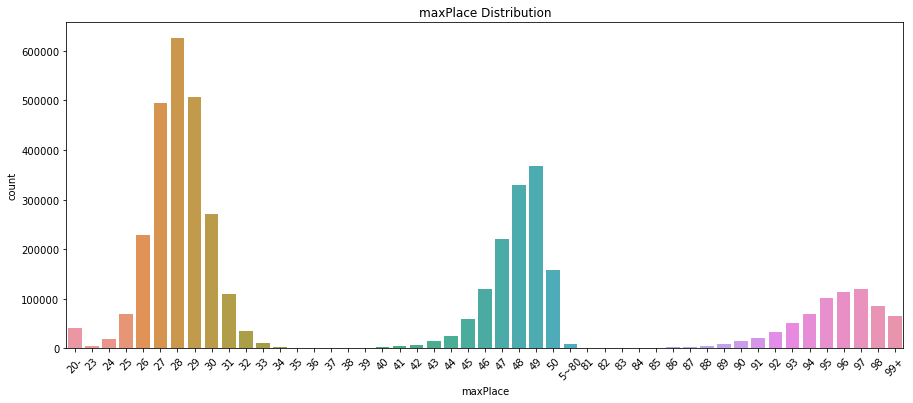

In [102]:
data = train["maxPlace"].copy()    #순서상 뒤의 heal 이상치를 알아보기 위한 과정
data.loc[(data<80)&(data>50)] = 80
data.loc[data<data.quantile(0.01)] = "20-"
data.loc[data==80] = "5~80"
data.loc[data==100] = 99
data.loc[data==99] = "99+"
plt.figure(figsize=(15,6))
plt.title("maxPlace Distribution")
plt.xticks(rotation = 45)
sns.countplot(data = data, x = data.astype(str).sort_values())

보통의 데이터 분포에서, maxPlace는 솔로, 듀오, 스쿼드 모드에서 각각 90대-40대-25 근처에 분포해 있음을 알 수 있다.

<AxesSubplot:xlabel='maxPlace', ylabel='count'>

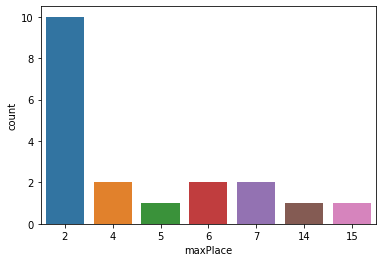

In [103]:
sns.countplot(data = train, x = train[(train.winPlacePerc==0)&(train.heals>15)]['maxPlace'])  #힐 이상 = 사설 소규모 게임

하지만 이동 거리가 0이고, 치료 아이템을 15개 이상 먹은 플레이어들이 플레이한 매치는 방 정원수가 이상할 정도로 낮음을 알 수 있다.


따라서, 이들이 불법 프로그램을 사용하지 않았다면, 커스텀 설정으로 시작하자마자 힐, 무기, 혹은 트리거 데미지들을 적용시켰기 때문에 이런 이상치가 나타났다고 추측할 수 있다.

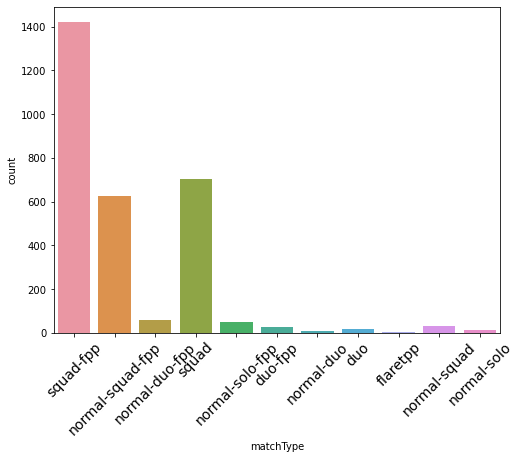

In [104]:
plt.figure(figsize=(8,6))
sns.countplot(data = train, x = train[(train.winPlacePerc==0)&(train.kills>1)]['matchType']) #그리고 극소수
plt.xticks(rotation=45, fontsize=14)
plt.show()

또한 이들의 matchType를 보았을 때, 이들이 주로 플레이한 방은 사설방(normal-)임을 알 수 있으며, 실제 매치에서 발견되는 이상치는 매우 적음을 알 수 있다.


이는 비인가 프로그램의 사용이라고도 볼 수 있지만, 우연히 기행을 한 플레이어나, 게임 db기록에 이상으로 인한 수치일 가능성도 배제할 수 없다.

<AxesSubplot:xlabel='maxPlace', ylabel='count'>

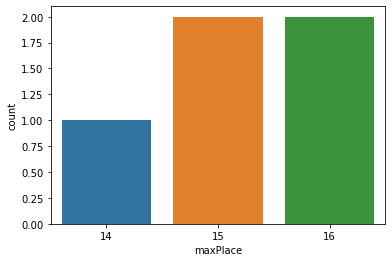

In [105]:
sns.countplot(data = train, x = train[(train.winPlacePerc==0)&(train.heals>10)&(train.matchType=='solo')]['maxPlace']) #1대1은 아님 (그래프 생략가능)

더불어 이 기이한 플레이어들의 방 정원수도 상당히 낮은 것으로 보아, 정상적인 게임 자체가 이루어지지 않았음을 유추할 수 있다.

### matchDuration

In [109]:
train[['winPlacePerc','matchDuration']].corr()

,winPlacePerc,matchDuration
winPlacePerc,1.00000,-0.00517
matchDuration,-0.00517,1.00000


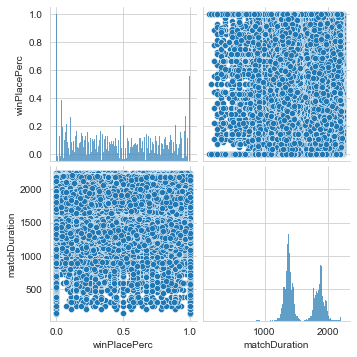

In [110]:
sns.pairplot(train[['winPlacePerc', 'matchDuration']])

- matchDuration 과 승리와의 상관관계는 뚜렷하게 보이지 않는것 같다 

## 상관관계와 다중공선성 확인

### 상관관계(Correlation)

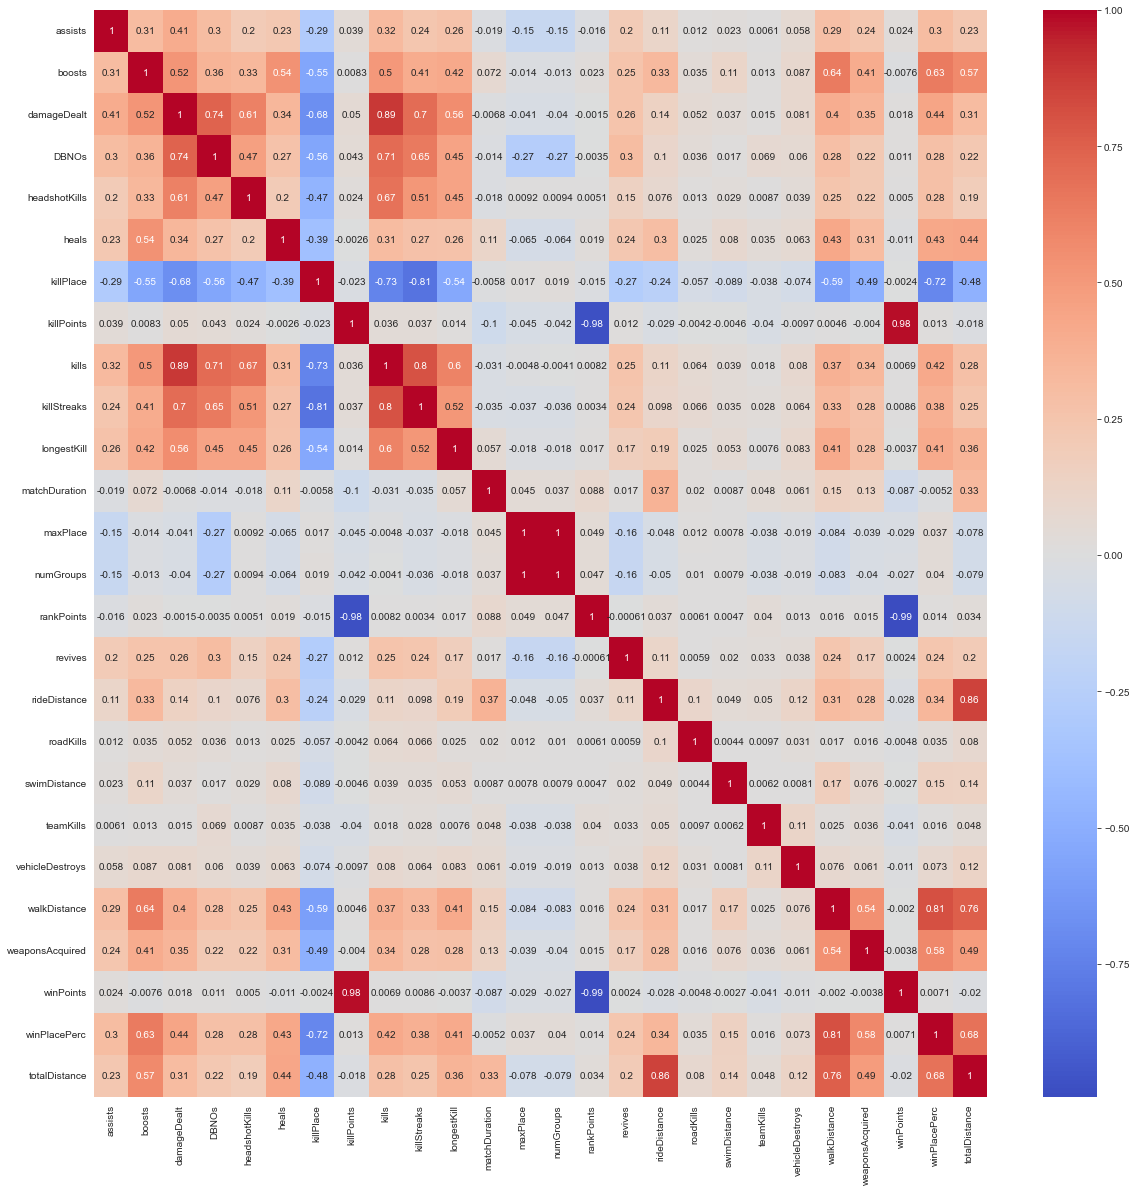

In [111]:
plt.figure(figsize=(20,20))
sns.heatmap(train.corr(),cmap='coolwarm',annot=True)
plt.show()

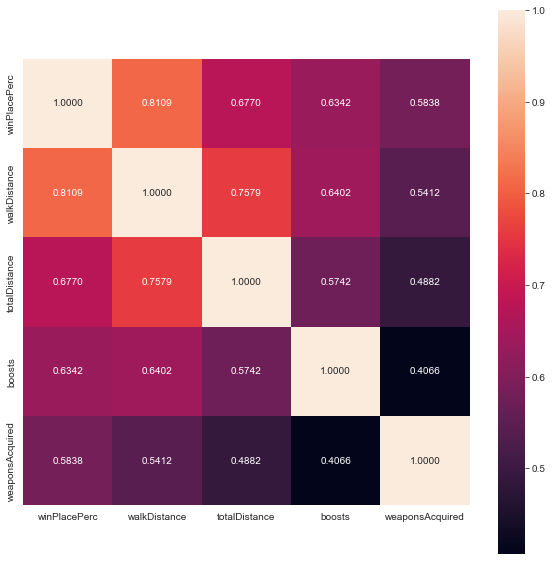

In [112]:
plt.figure(figsize=(10, 10))
cols = train.corr().nlargest(5, 'winPlacePerc')['winPlacePerc'].index
data = np.corrcoef(train[cols].values.T)
sns.heatmap(data, cbar=True, annot=True, square=True, fmt='.4f', annot_kws={'size': 10}, xticklabels=cols.values, yticklabels=cols.values)
plt.show()

In [113]:
sorted_corr(train, 'winPlacePerc')

,Correlation
walkDistance,0.810000
totalDistance,0.680000
boosts,0.630000
weaponsAcquired,0.580000
damageDealt,0.440000
heals,0.430000
kills,0.420000
longestKill,0.410000
killStreaks,0.380000
rideDistance,0.340000


In [114]:
sorted_corr(train, 'kills')

,Correlation
damageDealt,0.890000
killStreaks,0.800000
DBNOs,0.710000
headshotKills,0.670000
longestKill,0.600000
boosts,0.500000
winPlacePerc,0.420000
walkDistance,0.370000
weaponsAcquired,0.340000
assists,0.320000


#### VIF

In [115]:
train.columns

Index(['Id', 'groupId', 'matchId', 'assists', 'boosts', 'damageDealt', 'DBNOs',
       'headshotKills', 'heals', 'killPlace', 'killPoints', 'kills',
       'killStreaks', 'longestKill', 'matchDuration', 'matchType', 'maxPlace',
       'numGroups', 'rankPoints', 'revives', 'rideDistance', 'roadKills',
       'swimDistance', 'teamKills', 'vehicleDestroys', 'walkDistance',
       'weaponsAcquired', 'winPoints', 'winPlacePerc', 'totalDistance'],
      dtype='object')

In [138]:
features = train[['assists', 'boosts', 'damageDealt', 'DBNOs', 'headshotKills', 'heals',
       'killPlace', 'killPoints', 'kills', 'killStreaks', 'longestKill', 'matchDuration',
       'maxPlace', 'numGroups', 'rankPoints', 'revives', 'rideDistance',
       'roadKills', 'swimDistance', 'teamKills', 'vehicleDestroys',
       'walkDistance', 'weaponsAcquired','winPoints']]
toVIF(features)

TypeError: 'DataFrame' object is not callable

### OLS summary

In [119]:
features = train[['assists', 'boosts', 'damageDealt', 'DBNOs', 'headshotKills', 'heals',
       'killPlace', 'killPoints', 'kills', 'killStreaks', 'longestKill', 'matchDuration',
       'maxPlace', 'numGroups', 'rankPoints', 'revives', 'rideDistance',
       'roadKills', 'swimDistance', 'teamKills', 'vehicleDestroys',
       'walkDistance', 'weaponsAcquired','winPoints']]
OLS_summary(features, train.winPlacePerc)

                   Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.831        
Dependent Variable: winPlacePerc     AIC:                -5765184.8307
Date:               2022-06-17 11:25 BIC:                -5764852.1374
No. Observations:   4446965          Log-Likelihood:     2.8826e+06   
Df Model:           24               F-statistic:        9.081e+05    
Df Residuals:       4446940          Prob (F-statistic): 0.00         
R-squared:          0.831            Scale:              0.016014     
----------------------------------------------------------------------
                     Coef.  Std.Err.     t      P>|t|   [0.025  0.975]
----------------------------------------------------------------------
const                0.7215   0.0013   576.2934 0.0000  0.7191  0.7240
assists              0.0143   0.0001   123.4037 0.0000  0.0141  0.0145
boosts               0.0144   0.0001   269.9740 0.0000  0.0143  0.0145
damageDealt          0.000

## Conclusion

- Id, groupId, matchId 컬럼들은 modelling을 하는데 방해가 되는 feature들 이므로 feature enginnering 과정에서 사용하고 drop한다
- matchType은 ordinal encoding을 통해 수치화를 한다
- killPlace는 data leakage 문제로 drop을 하거나 변경을 한다
- kills와 damageDealt의 상관계수를 보면 0.89로 너무 높은 상관관계를 보여주기 때문에 damageDealt를 drop한다
- killPoints, rankPoints, winPoints 컬럼들은 winPlacePerc과의 관계에서 낮은 상관관계를 보여줌으로써 drop한다 
- matchDuration 컬럼은 winPlacePerc과의 관계에서 낮은 상관관계를 보여줌으로써 drop한다 